In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('feature-selection-clean.csv', index_col = 0)
df.reset_index( inplace = True, drop = True)

In [3]:
df.head()

,SCHOOL,STATE,ABBR,ID,COUNTY,LOCALE,TOTAL STUDENTS,FREE LUNCH ELIGIBLE,AMERICAN INDIAN,ASIAN,HISPANIC,BLACK,WHITE,FTE TEACHERS
0,1ST WARD EL,Wisconsin,WI,5.500000e+11,CHIPPEWA,4-Urban fringe of midsize city,193,35,1,0,0,0,192,0
1,4-J ELEMENTARY SCHOOL,Wyoming,WY,5.600000e+11,CAMPBELL,6-Small town,48,4,0,0,0,0,48,4
2,5TH AND 6TH GRADE CTR.,Missouri,MO,2.930000e+11,SCOTT,6-Small town,731,271,0,1,4,176,550,0
3,6TH GRADE CENTER,Texas,TX,4.820000e+11,HUNT,6-Small town,813,250,2,5,54,205,547,0
4,7TH AND 8TH GRADE CENTER,Missouri,MO,2.920000e+11,SAINT LOUIS,3-Urban fringe of large city,860,527,1,3,1,830,25,0


# Let us first create labels for our data

On our ground truth analysis, we had come up with a criteria to classify schools having more than 33.9% students eligible for free lunch as strictly poor, above 23.3% as poor and below 23.3% as not poor.

Based on that classification, we are going to create a label for our data and store it separate from our dataframe.

In [4]:
proportion = df['FREE LUNCH ELIGIBLE']/ df['TOTAL STUDENTS']

In [5]:
null_proportion = proportion[proportion.isna()== True].index

In [6]:
df.drop( null_proportion, inplace = True )

In [7]:
proportion = df['FREE LUNCH ELIGIBLE']/ df['TOTAL STUDENTS']

In [8]:
len(proportion[proportion.isna()== True].index)

0

In [9]:
df['HI-LABEL'] = proportion.apply( lambda x : 1 if (x > 0.233) else 0)

In [10]:
df['STRICT-LABEL'] = proportion.apply( lambda x : 1 if (x > 0.339) else 0)

In [11]:
df['HI-LABEL'].groupby(df['HI-LABEL']).size()

HI-LABEL
0    142139
1    168112
Name: HI-LABEL, dtype: int64

In [12]:
df['STRICT-LABEL'].groupby(df['STRICT-LABEL']).size()

STRICT-LABEL
0    189201
1    121050
Name: STRICT-LABEL, dtype: int64

We see that 142139 schools in our dataframe as labelled as non-poor, 47062 schools as poor and 121050 as strictly poor schools. High poverty includes strictly poor schools as a subset. Let us try to predict these labels using features from our dataset, and dropping free lunch column from our dataset.

# Feature Selection Process

In [13]:

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper


In [14]:
df.drop(columns = ['FREE LUNCH ELIGIBLE', 'SCHOOL', 'STATE', 'COUNTY','ID'], inplace = True)

In [15]:
display(df.head())

,ABBR,LOCALE,TOTAL STUDENTS,AMERICAN INDIAN,ASIAN,HISPANIC,BLACK,WHITE,FTE TEACHERS,HI-LABEL,STRICT-LABEL
0,WI,4-Urban fringe of midsize city,193,1,0,0,0,192,0,0,0
1,WY,6-Small town,48,0,0,0,0,48,4,0,0
2,MO,6-Small town,731,0,1,4,176,550,0,1,1
3,TX,6-Small town,813,2,5,54,205,547,0,1,0
4,MO,3-Urban fringe of large city,860,1,3,1,830,25,0,1,1


In [16]:
df.drop(df[df['TOTAL STUDENTS'] == 0].index, inplace = True)

In [17]:
high_y = df['HI-LABEL']
strict_y = df['STRICT-LABEL']
X = df.drop(columns = ['HI-LABEL', 'STRICT-LABEL'])

In [18]:
X.shape

(310212, 9)

In [19]:
high_y.shape

(310212,)

In [20]:
strict_y.shape

(310212,)

In [21]:
categorical_features = ['ABBR', 'LOCALE']
numerical_features = ['AMERICAN INDIAN', 'ASIAN', 'HISPANIC', 'BLACK', 'WHITE']

In [25]:
X[categorical_features] = df[categorical_features].astype('category')


for category in categorical_features:
    X[category] = X[category].cat.codes
    X[category] = X[category].astype('str')

for numeric in numerical_features:
    X[numeric] = (X[numeric]/X['TOTAL STUDENTS']) *100
    

# FEATURE SELECTION FOR high_y LABEL

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, high_y, stratify = high_y, random_state = 5)

In [28]:
X_train.shape

(232659, 9)

In [29]:
y_train.shape

(232659,)

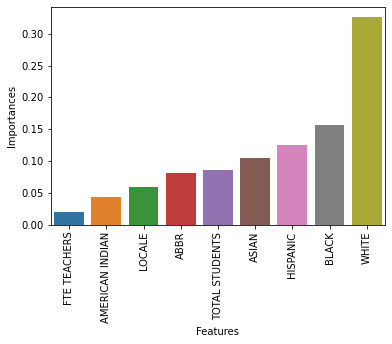

In [30]:
model = RandomForestClassifier( n_estimators = 500, min_samples_leaf = 50, random_state = 1 )

  
model.fit(X_train, y_train)

importances = model.feature_importances_

important_df = pd.DataFrame({"Features" : X_train.columns, "Importances" : importances})

important_df = important_df.sort_values('Importances')

ax = sns.barplot(data = important_df, x = 'Features', y = 'Importances')
ax.set_xticklabels( ax.get_xticklabels(), rotation = 90)
plt.show()

In [47]:
y_hi_pred = model.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [33]:
accuracy = accuracy_score(y_test, y_hi_pred)

In [34]:
print(accuracy)

0.7987827679135558


In [35]:
print(confusion_matrix( y_test, y_hi_pred))

[[28239  7296]
 [ 8309 33709]]


In [36]:
y_train_pred = model.predict( X_train)

In [37]:
print( accuracy_score(y_train_pred, y_train))

0.8136758088017227


In [48]:
print( confusion_matrix(y_test, y_hi_pred))

[[42515  4785]
 [ 8601 21652]]


# FEATURE SELECTION FOR strict_y LABEL

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, strict_y, stratify = strict_y, random_state = 5)

X_train[categorical_features] = df[categorical_features].astype('category')
X_test[categorical_features] = df[categorical_features].astype('category')

for category in categorical_features:
    X_train[category] = X_train[category].cat.codes
    X_test[category] = X_test[category].cat.codes
    X_train[category] = X_train[category].astype('str')
    X_test[category] = X_test[category].astype('str')

for numeric in numerical_features:
    X_train[numeric] = (X_train[numeric]/X_train['TOTAL STUDENTS']) *100
    X_test[numeric] = (X_test[numeric]/X_test['TOTAL STUDENTS']) * 100

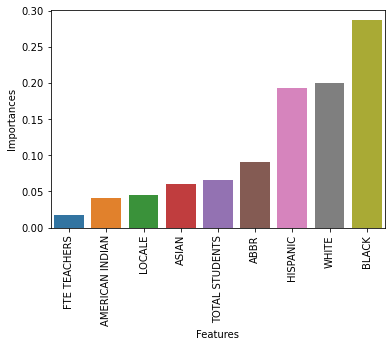

In [40]:
model = RandomForestClassifier( n_estimators = 500, min_samples_leaf = 50, random_state = 1 )

  
model.fit(X_train, y_train)

importances = model.feature_importances_

important_df = pd.DataFrame({"Features" : X_train.columns, "Importances" : importances})

important_df = important_df.sort_values('Importances')

ax = sns.barplot(data = important_df, x = 'Features', y = 'Importances')
ax.set_xticklabels( ax.get_xticklabels(), rotation = 90)
plt.show()

In [41]:
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7987827679135558


In [42]:
y_train_pred = model.predict( X_train)
train_accuracy = accuracy_score( y_train, y_train_pred)
print(train_accuracy)

0.8381193076562695


In [43]:
confusion_matrix(y_test, y_pred)

array([[42515,  4785],
       [ 8601, 21652]])

# Feature Selection using mutual gain info

In [50]:
from sklearn.feature_selection import mutual_info_classif

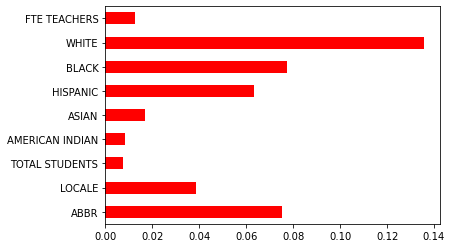

In [59]:
importances = mutual_info_classif(X, high_y)


feat_importances = pd.Series(importances, X.columns[0: len(X.columns)])
feat_importances.plot(kind = 'barh', color = 'red')
plt.show()

# Feature Selection using Correlation

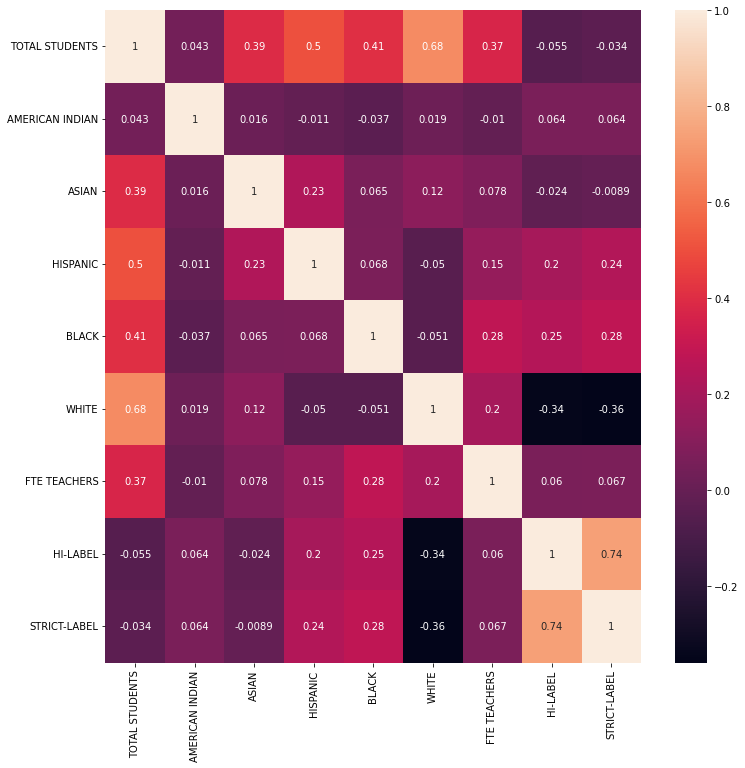

In [91]:
corr = df.corr()
plt.figure( figsize = (12,12))
sns.heatmap(corr, annot = True)
plt.show()

# Recursive Feature Elimination

In [63]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector

In [64]:
efs = ExhaustiveFeatureSelector(RandomForestClassifier(), scoring = 'roc_auc', cv = 2)

X_train, X_test, y_train, y_test = train_test_split(X, high_y, stratify = high_y, random_state = 5)

efs = efs.fit(X_train, y_train)

Features: 9/9

In [70]:
print(efs.best_score_)

0.7093307135139135


# LASSO Regularization

In [72]:
from sklearn.feature_selection import SelectFromModel

In [82]:
lr = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', random_state = 5).fit(X_train, y_train.values)

In [83]:
select_model = SelectFromModel(lr, prefit = True)

#X_train_new = select_model.transform( X_train)

In [89]:
feat_idx = select_model.get_support()
print( X_train.columns[feat_idx])

Index(['ABBR', 'LOCALE', 'TOTAL STUDENTS', 'ASIAN', 'HISPANIC', 'BLACK',
       'WHITE', 'FTE TEACHERS'],
      dtype='object')


# Conclusion

We will be using all columns except the 'FTE Teachers' and 'American Indian' columns that consistently performed poorly in all feature selection methods. With this we are ready to move to the Model Selection.